In [1]:
import random
import gym
from gym.spaces import Box
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import time
from CrimeWorldv2 import CrimeWorld
import matplotlib.pyplot as plt
import csv

EPISODES = 100

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size[0]
        self.action_size = action_size
        self.memory = deque(maxlen=1000)
        self.gamma = 0.99    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
#         model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Conv2D(4, input_shape=(self.state_size,self.state_size,1), kernel_size=(4,4), strides=(2,2), padding='valid', activation='relu'))
#         for layer in model.layers:
#             print(layer.output_shape)
        model.add(Conv2D(8, kernel_size=(4,4), strides=(2,2), padding='valid', activation='relu'))
#         model.add(Dense(24, activation='relu'))
#         model.add(Dense(self.action_size, activation='linear'))
#         for layer in model.layers:
#             print(layer.output_shape)
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
#             print(next_state.shape)
            if not done:
                target = (reward + self.gamma *np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


In [2]:

if __name__ == "__main__":
    env = CrimeWorld()
    x = 60
    y = 60
    env.add_agent(x,y)
    police_state_size = env.get_state().shape
    action_size = 5
    agent = DQNAgent(police_state_size, action_size)
    # agent.load("./save/cartpole-dqn.h5")
    done = False
    batch_size = 32


In [3]:
save_episode = []
for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, (1, police_state_size[0], police_state_size[1],1))
    for time_step in range(1000):
        # env.render()
        action = agent.act(state)
        reward, next_state, done = env.step(action)
#         reward = reward if not done else -10
        next_state = np.reshape(next_state, (1, police_state_size[0],police_state_size[1],1))
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        save_episode.append([e, env.policeX, env.policeY , action, reward, env.save_result(action, reward)[0], env.save_result(action, reward)[1]])
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    if(e%10==9):
        file_name = str(e) + ".csv"
        with open(file_name, mode='a') as csv_file:
            writer = csv.writer(csv_file, delimiter=',')
            writer.writerows(save_episode)
        save_episode = []
    

/home/smohnot/Desktop/project/dqn model/CrimeWorldv2.py:229: RuntimeWarning: invalid value encountered in double_scalars
  p1 = A[i1,j] / totalA
/home/smohnot/Desktop/project/dqn model/CrimeWorldv2.py:230: RuntimeWarning: invalid value encountered in double_scalars
  p2 = p1 + A[i2,j] / totalA
/home/smohnot/Desktop/project/dqn model/CrimeWorldv2.py:231: RuntimeWarning: invalid value encountered in double_scalars
  p3 = p2 + A[i,j3] / totalA


In [32]:
99 % 10

9

<Figure size 432x288 with 0 Axes>

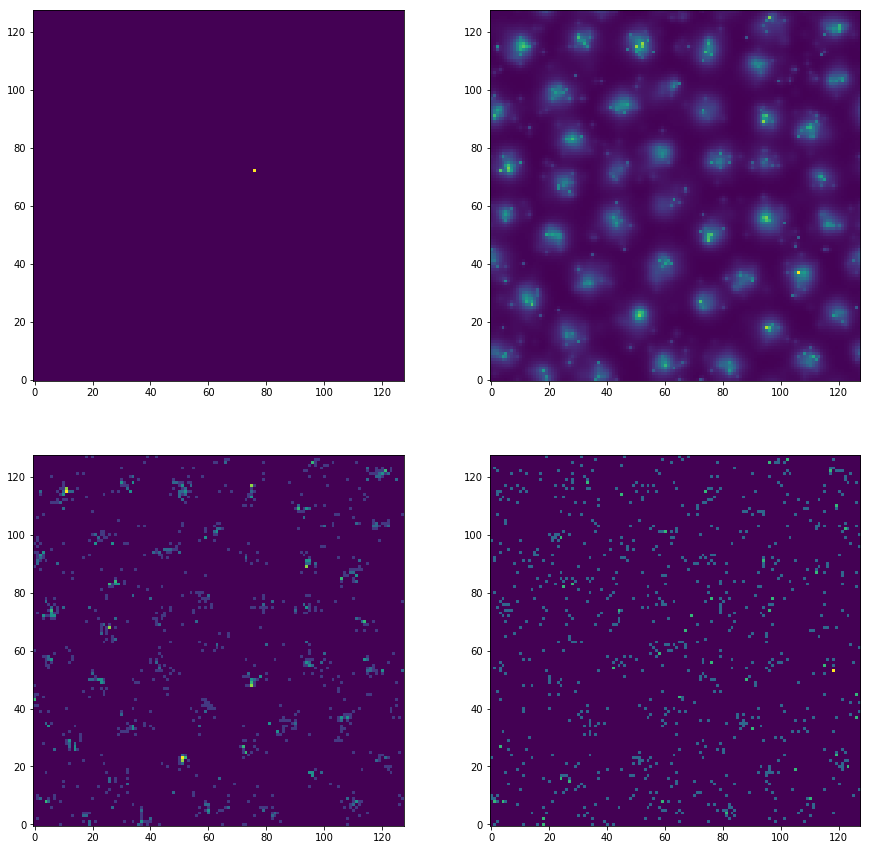

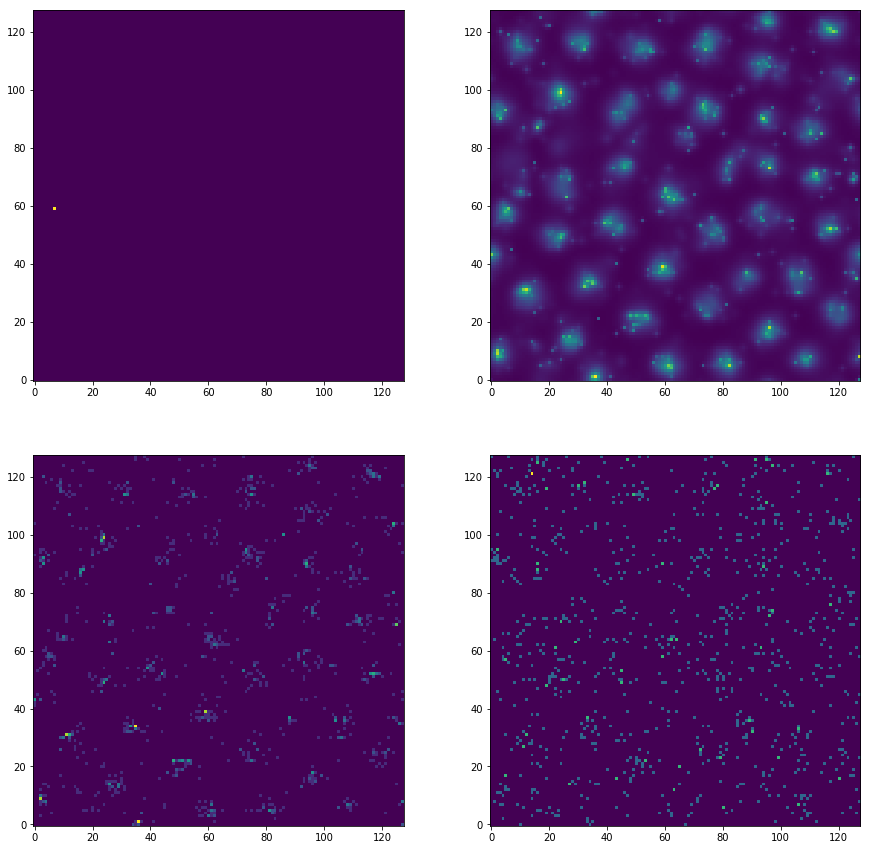

In [4]:
import matplotlib.pyplot as plt
f_inital = np.load('990.npz')
f_final = np.load('99999.npz')
h_inital = np.load('490.npz')
h_final = np.load('49999.npz')

plt.clf()
fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(15,15))
ax1.imshow(f_inital['P'])
ax2.imshow(f_inital['B'])
ax3.imshow(f_inital['totalC'])# dynamic attractiveness
ax4.imshow(f_inital['n'])

ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
ax4.invert_yaxis()

fig1, ((ax5,ax6), (ax7, ax8)) = plt.subplots(nrows=2,ncols=2,figsize=(15,15))
ax5.imshow(f_final['P'])       # burglar count
ax6.imshow(f_final['B'])
ax7.imshow(f_final['totalC'])
ax8.imshow(f_final['n'])
ax5.invert_yaxis()
ax6.invert_yaxis()
ax7.invert_yaxis()
ax8.invert_yaxis()


# running crime count (state)
# display.clear_output(wait=True)
# display.display(plt.gcf())


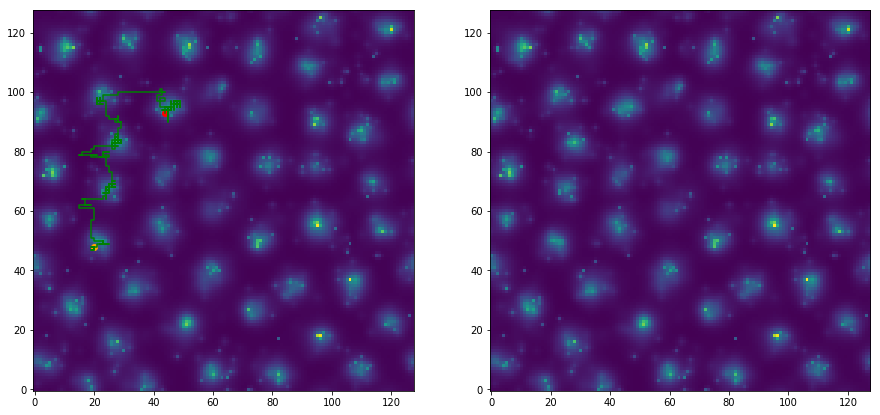

In [15]:
import pandas as pd

f_inital = np.load('990.npz')
f_final = np.load('99999.npz')
h_inital = np.load('490.npz')
h_final = np.load('49999.npz')

police_data = pd.read_csv("result_output_new.csv")

fig ,(ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(15,10))

policeX = police_data.policeX.values[:1000]
policeY = police_data.policeY.values[:1000]

ax1.scatter(policeX[0], policeY[0], color='red')
ax1.scatter(policeX[-1], policeY[-1], color='orange')
ax1.plot(policeX, policeY, color='green')
ax1.imshow(h_inital['B'])
ax2.imshow(h_inital['B'])
ax1.invert_yaxis()
ax2.invert_yaxis()
plt.show()

# policeX = police_data.policeX.values[1000:]
# policeY = police_data.policeY.values[1000:]
# ax1.scatter(policeX[0], policeY[0], color='red')
# ax1.scatter(policeX[-1], policeY[-1], color='orange')
# ax1.plot(policeX, policeY, color='green')
# ax1.imshow(f_inital['B'])
# ax2.imshow(f_inital['B'])
# ax1.invert_yaxis()
# ax2.invert_yaxis()
# plt.show()